In [1]:
import numpy
from numba import jit

$$
p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}-\frac{\rho\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)} \times$$

$$\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right. $$

$$ -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]$$

In [2]:
def bracket_term_ppe(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (
        rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                         (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                    2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                         (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                        ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)
                    )

    return b


In [3]:
b = numpy.zeros((5,5))
u = numpy.zeros((5,5))
v = numpy.zeros((5,5))
dx = 0.1
dy = 0.1
dt = 0.1
rho = 1.
bracket_term_ppe(b, rho, dt, u, v, dx, dy)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

$$
p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}-\frac{\rho\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)} \times$$

$$\left[\frac{1}{\Delta t}\left(\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}+\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right)-\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\frac{u_{i+1,j}-u_{i-1,j}}{2\Delta x}\right. $$

$$ -2\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta y}\frac{v_{i+1,j}-v_{i-1,j}}{2\Delta x}-\left.\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\frac{v_{i,j+1}-v_{i,j-1}}{2\Delta y}\right]$$

In [4]:
@jit(nopython=True)
def pressure_poisson(p, dx, dy, b, l2_target=1e-4):
    #pn = numpy.empty_like(p)
    pn = p.copy()
    I, J = b.shape
    n = 0
    
    iter_diff = l2_target + 1
    
    while iter_diff > l2_target:
        pn = p.copy()
        for j in range(1, J - 1):
            for i in range(1, I - 1):
                p[j, i] = (((pn[j, i + 1] + pn[j, i - 1]) * dy**2 + 
                        (pn[j + 1, i] + pn[j - 1, i]) * dx**2) /
                        (2 * (dx**2 + dy**2)) -
                        dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                        b[j, i])

        for j in range(J):
            p[j, 0] = p[j, 1]
            p[j, -1] = p[j, -2]
            
        for i in range(I):
            p[0, i] = p[1, i]
            p[-1, i] = 0
            
        iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        n += 1
        
        if n == 500:
            break
#          p[:, -1] = p[:, -2] #dp/dy = 0 at x = 2
#          p[0, :] = p[1, :] #dp/dy = 0 at y = 0
#          p[:, 0] = p[:, 1] #dp/dx = 0 at x = 0
#          p[-1, :] = 0 #p = 0 at y = 2
        
    return p

In [5]:
b.shape

(5, 5)

In [6]:
b = bracket_term_ppe(b, rho, dt, u, v, dx, dy)

In [7]:
p = numpy.random.random((5,5))

In [8]:
pressure_poisson(p, dx, dy, b)

array([[  6.97608288e-12,   6.97608288e-12,   6.97608288e-12,
          6.97608288e-12,   6.97608288e-12],
       [  6.97608288e-12,   6.97608288e-12,   6.97608288e-12,
          6.97608288e-12,   6.97608288e-12],
       [  5.59438411e-12,   5.59438411e-12,   5.59438411e-12,
          5.59438411e-12,   5.59438411e-12],
       [  3.10464896e-12,   3.10464896e-12,   3.10464896e-12,
          3.10464896e-12,   3.10464896e-12],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]])

In [9]:
# pressure_poisson.inspect_types()

The momentum equation in the $u$ direction:

$$
u_{i,j}^{n+1} = u_{i,j}^{n} - u_{i,j}^{n}\frac{\Delta t}{\Delta x}(u_{i,j}^{n}-u_{i-1,j}^{n})
- v_{i,j}^{n}\frac{\Delta t}{\Delta y}(u_{i,j}^{n}-u_{i,j-1}^{n})$$
$$-\frac{\Delta t}{\rho 2\Delta x}(p_{i+1,j}^{n}-p_{i-1,j}^{n})
+\nu\left(\frac{\Delta t}{\Delta x^2}(u_{i+1,j}^{n}-2u_{i,j}^{n}+u_{i-1,j}^{n})\right.
+\left.\frac{\Delta t}{\Delta y^2}(u_{i,j+1}^{n}-2u_{i,j}^{n}+u_{i,j-1}^{n})\right)
$$

The momentum equation in the $v$ direction:

$$v_{i,j}^{n+1} = v_{i,j}^{n}-u_{i,j}^{n}\frac{\Delta t}{\Delta x}(v_{i,j}^{n}-v_{i-1,j}^{n})
- v_{i,j}^{n}\frac{\Delta t}{\Delta y}(v_{i,j}^{n}-v_{i,j-1}^{n})$$
$$
-\frac{\Delta t}{\rho 2\Delta y}(p_{i,j+1}^{n}-p_{i,j-1}^{n})
+\nu\left(\frac{\Delta t}{\Delta x^2}(v_{i+1,j}^{n}-2v_{i,j}^{n}+v_{i-1,j}^{n})\right.
+\left.\frac{\Delta t}{\Delta y^2}(v_{i,j+1}^{n}-2v_{i,j}^{n}+v_{i,j-1}^{n})\right)$$

In [10]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = bracket_term_ppe(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1,1:-1] = (un[1:-1, 1:-1] -
                        un[1:-1,1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1 ] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) *
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * dt *
                        (1 / dx**2 *
                         (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        1 / dy**2 *
                         (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) *
                        (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * dt *
                        (1 / dx**2 *
                         (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        1 / dy**2 *
                         (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] +vn[0:-2, 1:-1])))

        #remember order of these will have a (very small) effect on the 
        #final answers.  if you want to compare between versions, make sure
        #they match up
        u[:, 0] = 0
        u[:, -1] = 0
        v[:, 0] = 0
        v[:, -1] = 0
        u[0, :] = 0
        u[-1, :] = 1    #set velocity on cavity lid equal to 1
        v[0, :] = 0
        v[-1, :]=0
        
        
        
    return u, v, p

In [11]:
nx = ny = 101
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.random.random((ny, nx))
b = numpy.zeros((ny, nx))

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = 0.1
dt = .0005

nt = 400
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [12]:
from matplotlib import pyplot, cm
%matplotlib inline

In [13]:
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

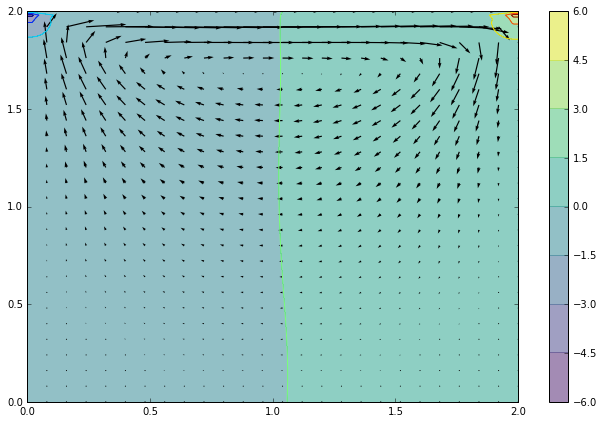

In [14]:
quiver_skip = qs = 4
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p)
pyplot.quiver(X[::qs, ::qs], Y[::qs, ::qs], u[::qs, ::qs], v[::qs, ::qs])

In [15]:
p

array([[-0.05221462, -0.05221462, -0.05236049, ...,  0.04179788,
         0.0416491 ,  0.0416491 ],
       [-0.05221462, -0.05221462, -0.05236049, ...,  0.04179788,
         0.0416491 ,  0.0416491 ],
       [-0.05205938, -0.05205938, -0.05220662, ...,  0.04164423,
         0.04149253,  0.04149253],
       ..., 
       [-3.52584322, -3.52584322, -2.60911982, ...,  2.81832253,
         3.77114183,  3.77114183],
       [-4.95482116, -4.95482116, -3.31004329, ...,  3.50809059,
         5.18918273,  5.18918273],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
def run_cavity():
    nx = ny = 101
    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.random.random((ny, nx))
    b = numpy.zeros((ny, nx))

    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    rho = 1
    nu = 0.1
    dt = .0001

    nt = 100
    u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [17]:
%load_ext line_profiler

In [18]:
%lprun -f cavity_flow run_cavity()

In [37]:
%timeit run_cavity()

1 loop, best of 3: 6.87 s per loop
